In [71]:
import warnings
%load_ext autoreload
%autoreload 2
warnings.simplefilter('ignore')

# "chr=conceded-home-rolling"
# "car=conceded-away-rolling"
# "hr=home-rolling"
# "ar=away-rolling"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
from preprocess import pack
from features import Features, feature_selection
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import optimization
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
import numpy as np
from collections import OrderedDict
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score
import pandas as pd
import seaborn as sns

In [73]:
feat = Features(**pack)
data = feat.execute()
container = feature_selection(data)
trainx = container.trainx
trainy = container.trainy

def encoder(data,feat):
    from sklearn.preprocessing import OrdinalEncoder
    oe=OrdinalEncoder()
    data[feat]=oe.fit_transform(data[feat])
    return data

trainx=encoder(trainx,['hometeam','awayteam','referee','season'])

In [74]:
trainx,valx,trainy,valy=train_test_split(trainx,trainy)

In [75]:
best_params = optimization.optimizer(trainx,trainy, 'XGBoost_classif')

XGBoost_classif took 923.61 seconds,  candidates checked: 120, best CV score: 0.592 ± 0.003
Best parameters:
OrderedDict([('colsample_bytree', 1.0),
             ('learning_rate', 0.01),
             ('max_depth', 4),
             ('n_estimators', 257),
             ('reg_lambda', 22.485977903954552),
             ('subsample', 0.5325852461953129)])


In [76]:
# best_params['reg_lambda']+=100
# best_params['subsample']=0.2

In [77]:

# best_params = OrderedDict([('colsample_bytree', 1.0),
#                            ('learning_rate', 0.14006304478391782),
#                            ('max_depth', 10),
#                            ('n_estimators', 50),
#                            ('subsample', 1.0)])

    # xgb_param = model.get_xgb_params()
    # xgb_param['num_class'] = 3
    # cvresult = xgb.cv(xgb_param, ...)


model = XGBClassifier(random_state=0, booster='gbtree', tree_method='hist',objective='multi:softprob',
                      eval_metric=accuracy_score, verbosity=0, num_class=3, grow_policy='lossguide', **best_params)


def train(trainx, trainy):
    folds = 10
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=0)
    train_acc, val_acc = [], []
    
    
    for k, (train_idx, val_idx) in enumerate(skf.split(trainx, trainy)):
        model.fit(trainx.iloc[train_idx].values, trainy.iloc[train_idx].values)
        train_preds = model.predict(trainx.iloc[train_idx].values)
        val_preds = model.predict(trainx.iloc[val_idx].values)
        
        acc_t = accuracy_score(
            y_true=trainy.iloc[train_idx].values, y_pred=train_preds)
        acc_v = accuracy_score(
            y_true=trainy.iloc[val_idx].values, y_pred=val_preds)
        train_acc.append(acc_t)
        val_acc.append(acc_v)
    return np.mean(train_acc), np.mean(val_acc)


In [78]:
# import features
# best = features.auto_best_features(trainx, trainy, n_features=30)

In [79]:
model.fit(trainx,trainy)
t_preds=model.predict(trainx)
v_preds=model.predict(valx)

In [80]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(t_preds,trainy))
print(f1_score(t_preds,trainy,average='weighted'))
print(recall_score(t_preds,trainy,average='weighted'))
print(precision_score(t_preds,trainy,average='weighted'))
accuracy_score(t_preds,trainy)

[[  61   13   15]
 [ 550 1264  375]
 [ 952  530 2456]]
0.6825515408169871
0.6082689832689833
0.7936038587754342


0.6082689832689833

In [81]:
print(confusion_matrix(v_preds,valy))
print(f1_score(v_preds,valy,average='weighted'))
print(recall_score(v_preds,valy,average='weighted'))
print(precision_score(v_preds,valy,average='weighted'))
accuracy_score(v_preds,valy)

[[  8   8  10]
 [173 424 142]
 [325 178 805]]
0.6729743794421154
0.596719729860106
0.7787397128139061


0.5967197298601061

In [12]:
# mi = features.mutual_information(best, trainy)
# features.plotmi(mi)

In [39]:
# train_acc,val_acc=train(best, trainy)
# train_acc,val_acc



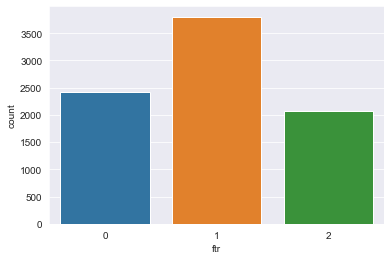

In [80]:
sns.countplot(trainy);

In [82]:
train(trainx,trainy)

(0.9823862979360414, 0.5702755779327867)

In [ ]:
# find the optimal parameters and by training and validating multiple times -the training and validation can be daone in loop or in single sert

In [16]:
import torch
from torch.utils.data import DataLoader

class Loader:
    def __init__(self,x,y):
        self.trainx=x.values
        self.trainy=y.values
    def __len__(self):
        return len(self.trainx)
    def __getitem__(self,idx):
        return {'x':self.trainx[idx],'y':self.trainy[idx]}
    


In [55]:
epochs=10
t_x,v_x,t_y,v_y=train_test_split(trainx,trainy,test_size=0.2)
trainloader=DataLoader(Loader(t_x,t_y),batch_size=64)
val_loader=DataLoader(Loader(v_x,v_y),batch_size=8)
best_params = OrderedDict([('colsample_bytree', 1.0),
                           ('learning_rate', 0.14006304478391782),
                           ('max_depth', 10),
                           ('n_estimators', 50),
                           ('subsample', 1.0)])
model = XGBClassifier(random_state=0, booster='gbtree', tree_method='hist', eval_metric='mlogloss', objective='multi:softprob' ,verbosity=0, **best_params)
model.fit(t_x,t_y)